In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg

In [833]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spatrix=sp.coo_matrix
sp_format='coo'

In [763]:
ci=spatrix(np.array([[1,0],[0,1]]),dtype=complex)
cz=spatrix(np.array([[1,0],[0,-1]]),dtype=complex)
cx=spatrix(np.array([[0,1],[1,0]]),dtype=complex)
cy=spatrix(np.array([[0,-1j],[1j,0]]),dtype=complex)


In [764]:
def lkron(arr):
    acc=arr[0]
    for i in range(1,len(arr)):
        acc = sp.kron(acc,arr[i],sp_format)
    return acc

In [853]:
def sign(i):
    return +1 if i>0 else -1 if i<0 else 0

def mj(size,posmat1=None,posmat2=None,posmat3=None):
    a = [ci for i in range(size)]
    if posmat1!=None : a[posmat1[0]]=posmat1[1]
    if posmat2!=None : a[posmat2[0]]=posmat2[1]
    if posmat3!=None : a[posmat3[0]]=posmat3[1]
    return lkron(a)

def Cijm(cl,size):
    return mj(size)+\
        mj(size,(abs(cl[0])-1,sign(cl[0])*cz),(abs(cl[1])-1,sign(cl[1])*cz))+\
        mj(size,(abs(cl[1])-1,sign(cl[1])*cz),(abs(cl[2])-1,sign(cl[2])*cz))+\
        mj(size,(abs(cl[2])-1,sign(cl[2])*cz),(abs(cl[0])-1,sign(cl[0])*cz))
    s1=[ci for k in range(size)]
    s2=[ci for k in range(size)]
    s3=[ci for k in range(size)]
    s4=[ci for k in range(size)]
    s2[abs(cl[0])-1] = sign(cl[0])*cz
    s2[abs(cl[1])-1] = sign(cl[1])*cz
    s3[abs(cl[1])-1] = sign(cl[1])*cz
    s3[abs(cl[2])-1] = sign(cl[2])*cz
    s4[abs(cl[2])-1] = sign(cl[2])*cz
    s4[abs(cl[0])-1] = sign(cl[0])*cz
    return (lkron(s1)+lkron(s2)+lkron(s3)+lkron(s4))/4
    

In [854]:
def BauerFikeStep(Hp,Hb,neigs=3,start=1,stop=0,accuracy=1e-15):
    dparam = abs(sp.linalg.eigsh(-Hp+Hb,1,which='LM',return_eigenvectors =False)[0])
    if stop>start: dparam = -dparam

    param = start # 0 - hp, 1 - hb
    e = sorted(sp.linalg.eigsh((1-param)*Hp+param*Hb,neigs,which='SA',return_eigenvectors =False))
    
    print(param,e)
    pacc=[param]
    eacc=[[e[i]] for i in range(neigs)]
    
    while e[1]-e[0]>accuracy and param>=min(start,stop) and param <=max(start,stop):
        param-=0.4*(e[1]-e[0])/dparam
        e = sorted(sp.linalg.eigsh((1-param)*Hp+param*Hb,neigs,which='SA',return_eigenvectors =False))
        
        print(param,e)
        pacc.append(param)
        for i in range(neigs):
            eacc[i].append(e[i])
    return (pacc,eacc)

задаём NAE3SAT (в difficult-SAT.ipynb уже проверили, что там только 2 решения (у NAE3SAT всегда чётное число решений))
и строим hp - гамильтониан проблемы

In [787]:
NAE3SAT = [[1, -2, -6], [-1, 2, 6], [-1, -2, -7], [1, -2, -7], [-1, -3, -4], 
     [1, 3, 5], [1, -3, 5], [-1, 4, -6], [-1, -5, -7], [-2, -3, 4], 
     [2, -4, -6], [-2, 4, -8], [-3, -4, 5], [-3, 5, -8], [3, 6, -7], 
     [-4, -5, -6], [4, 6, 7], [-4, 6, 8], [4, 6, 8], [4, -6, 8], [-5, -6, 8], [-5, 7, -8], [-5, -7, 8]]
size = max([max([abs(lit) for lit in clause]) for clause in NAE3SAT])
print(size)

8


# С расщеплением $0.1\sigma_0^z$

ищем СВ Hp и их ненулевые координаты дают нам решения (которые совпадают с теми, что выдал pycosat)

In [855]:
Hp1 = sum([Cijm(cl,size) for cl in NAE3SAT]) - 0.1*mj(size,(0,sz))

# -0.1*sum([mj(size,(i,sz)) for i in range(size)])#
#print(hp)
#np.array(hp)

e,v = sp.linalg.eigsh(Hp1,3,which='SA',return_eigenvectors =True)
print(e)
print(sorted(e))

#v2 = [[v[j,i] if abs(v[j,i])>1e-12 else 0 for j in range(len(v))] for i in range(len(v[0]))]
#print(v2)
for i in range(len(v[0])):
    for j in range(len(v)):
        if abs(v[j,i])>1e-12:
            print(i,'{0:b}'.format(j),j, v[j,i])
     

[ 0.1 -0.1  3.9]
[-0.10000000000000434, 0.09999999999999568, 3.9000000000000177]
0 11010100 212 (0.5653903961470574+0.8248234356179964j)
1 101011 43 (0.5766229384442367-0.8170103958089748j)
2 101111 47 (0.6333963922453083+0.7738275068066739j)


задаем стартовый гамильтониан hb - тензорное произведение $\sigma^x$

In [852]:
Hb = sum([mj(size,(i,sx)) for i in range(size)])   #lkron([sx for i in range(size)])
e,v = sp.linalg.eigsh(Hb,20,which='SA',return_eigenvectors =True)
print(sorted(e))

#print(hb)

[-8.000000000000055, -6.00000000000027, -6.0000000000002425, -6.000000000000217, -6.000000000000179, -6.000000000000156, -6.000000000000155, -6.000000000000054, -6.000000000000043, -4.000000000000172, -4.000000000000156, -4.000000000000133, -4.000000000000115, -4.000000000000111, -4.000000000000099, -4.000000000000073, -4.000000000000071, -4.000000000000013, -4.000000000000002, -2.000000000000081]


по
https://en.wikipedia.org/wiki/Bauer%E2%80%93Fike_theorem#The_Bauer%E2%80%93Fike_Theorem
будем определять на какой шаг можно прыгнуть

эволюцию начнем с hp и будем двигаться к hb

In [821]:
pacc,eacc = BauerFikeStep(Hp1,Hb)

1 [-8.0, -6.000000000000007, -6.000000000000004]
0.9450658995315471 [-7.247442243857245, -5.445330087349476, -5.417944203170421]
0.8955671944010378 [-6.574782385998695, -4.951752006642445, -4.8976837316168504]
0.850987337439584 [-5.974322479888161, -4.513210545086765, -4.433033956884094]
0.8108549025285661 [-5.4390118445151865, -4.12414503507667, -4.018342697312987]
0.7747393898224012 [-4.962388756446087, -3.7794485022349975, -3.648449166970027]
0.7422475104358965 [-4.538529962956503, -3.474433033222843, -3.3186475254934185]
0.7130199066128159 [-4.162007277433078, -3.204800637658215, -3.024654074130008]
0.6867282637535845 [-3.8278503748350023, -2.966618755147478, -2.7625772837990037]
0.663072771592323 [-3.531514797380465, -2.7562994388464963, -2.5288900211157777]
0.6417798923971266 [-3.26885413060351, -2.5705811621385597, -2.32040351882207]
0.6226003936950973 [-3.0360953263387676, -2.4065121819792346, -2.1342427857638033]
0.6053076018423518 [-2.829816228239274, -2.2614344792200973, -1.

0.1987086195952888 [-0.24579550522217156, -0.08684224204469117, 0.634491435926659]
0.1943426423306987 [-0.2382694416581134, -0.07837577417834105, 0.6428378153253521]
0.18995083493389708 [-0.2309341182760029, -0.07009695970614106, 0.6510765082660817]
0.18553311261992844 [-0.22379032811532898, -0.06200653722782734, 0.6592093988517408]
0.18108938910853783 [-0.21683884991866634, -0.05410523275268254, 0.667238286808768]
0.17661957667104236 [-0.21008044755946786, -0.046393759033038266, 0.6751648927947382]
0.17212358617461274 [-0.2035158694673764, -0.0388728148977627, 0.6829908631009283]
0.16760132712403267 [-0.19714584805449198, -0.03154308459030213, 0.6907177738203667]
0.16305270770103503 [-0.19097109914612798, -0.024405237115456117, 0.6983471345438932]
0.1584776348013313 [-0.18499232141966604, -0.017459925599021122, 0.7058803916396011]
0.15387601406946533 [-0.17921019585503672, -0.010707786664008134, 0.7133189311649225]
0.14924774993162715 [-0.17362538520027054, -0.004149439827020286, 0.72

In [830]:
print('min',min(np.array(eacc[1])-np.array(eacc[0])))
print('max',max(np.array(eacc[1])-np.array(eacc[0])))


min 0.11591137777590199
max 1.999999999999993


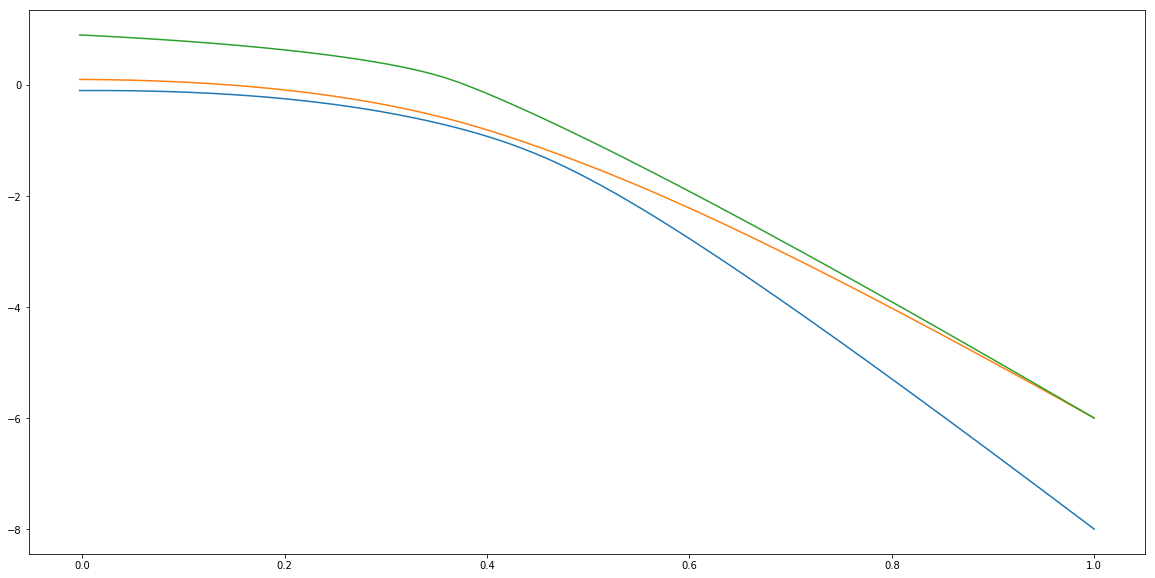

In [838]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(np.array(pacc), np.array(eacc[0]))
ax.plot(np.array(pacc), np.array(eacc[1]))
ax.plot(np.array(pacc), np.array(eacc[2]))
plt.show()

# с инверсией и расщеплением как в статье

In [856]:
def Aijm(cl,size):
    ss = {i for i in range(size)}-{abs(cl[0])-1,abs(cl[1])-1,abs(cl[2])-1}
    i = iter(ss)
    r= next(i)
    s= next(i)
    return 2*mj(size)+\
        mj(size,(abs(cl[0])-1,cx),(abs(cl[1])-1,cx),(abs(cl[2])-1,cx))+\
        mj(size,(r,cx),(s,cx))


In [848]:
Hp2 = sum([Cijm(cl,size)@Aijm(cl,size)@Cijm(cl,size) for cl in NAE3SAT])
pacc2,eacc2 = BauerFikeStep(Hp2,Hb,accuracy=1e-14)

1 [-8.000000000000007, -6.000000000000008, -6.000000000000004]
0.9730108517736281 [-7.357779726285068, -5.691687341267986, -5.589091093588882]
0.9505276446046004 [-6.8322527741209145, -5.436970603917528, -5.2499610313109155]
0.9316989059499838 [-6.399969285210934, -5.2251626756517116, -4.968293666940406]
0.9158453910886262 [-6.042400119142651, -5.047910335575981, -4.73286574843444]
0.9024251749994795 [-5.744921353724402, -4.898657736685379, -4.534861254506742]
0.8910052079000536 [-5.495988720500135, -4.772237116746338, -4.367332807790877]
0.8812384882436607 [-5.286475931277323, -4.664555181898141, -4.224782566720836]
0.8728459325986352 [-5.109149926757065, -4.5723524445903765, -4.102838047395587]
0.8656020791917651 [-4.9582581151980785, -4.493018449612438, -3.99800229293839]
0.8593238680441259 [-4.829205726089622, -4.424449828356391, -3.907461686979667]
0.8538618595844156 [-4.718304718317152, -4.364941130452944, -3.828938142972443]
0.8490933684590808 [-4.622578896952126, -4.31310070313

0.811467706870484 [-3.9079231456586982, -3.9079031498768884, -3.227707228594153]
0.8114674370359244 [-3.9079183074864865, -3.9079002695661575, -3.227703450709306]
0.8114671936218717 [-3.9079139430415526, -3.90789767127767, -3.2277000427318057]
0.811466974041348 [-3.9079100059379774, -3.9078953273970676, -3.227696968441885]
0.8114667759606898 [-3.9079064543319313, -3.907893213013898, -3.2276941951663405]
0.8114665972747422 [-3.907903250477063, -3.907891305656904, -3.227691693431372]
0.8114664360844813 [-3.9079003603231093, -3.9078895850552122, -3.227689436649173]
0.8114662906768301 [-3.9078977531539176, -3.907888032922776, -3.2276874008353156]
0.8114661595064505 [-3.9078954012611336, -3.9078866327640824, -3.227685564353879]
0.8114660411793172 [-3.9078932796494055, -3.907885369698794, -3.2276839076874126]
0.8114659344379025 [-3.9078913657709604, -3.907884230303589, -3.227682413229617]
0.8114658381478093 [-3.9078896392858025, -3.9078832024694923, -3.227681065098046]
0.8114657512857145 [-3

0.811464951087209 [-3.9078737342810763, -3.9078737336770297, -3.2276686456061605]
0.8114649510790576 [-3.9078737341349243, -3.907873733590009, -3.2276686454920407]
0.8114649510717041 [-3.90787373400308, -3.9078737335115186, -3.227668645389087]
0.8114649510650708 [-3.9078737338841414, -3.9078737334407094, -3.2276686452962102]
0.8114649510590869 [-3.9078737337768414, -3.907873733376828, -3.2276686452124324]
0.8114649510536889 [-3.90787373368006, -3.907873733319211, -3.227668645136849]
0.8114649510488193 [-3.9078737335927607, -3.9078737332672446, -3.2276686450686762]
0.8114649510444266 [-3.9078737335139935, -3.9078737332203457, -3.227668645007184]
0.811464951040464 [-3.9078737334429405, -3.907873733178057, -3.227668644951699]
0.8114649510368895 [-3.907873733378847, -3.9078737331398883, -3.2276686449016343]
0.8114649510336649 [-3.9078737333210207, -3.907873733105471, -3.2276686448565135]
0.8114649510307561 [-3.9078737332688718, -3.90787373307441, -3.22766864481578]
0.8114649510281319 [-3.9

0.8114649510039567 [-3.9078737327883624, -3.90787373278835, -3.2276686444405738]
0.8114649510039564 [-3.907873732788355, -3.9078737327883477, -3.227668644440572]


In [849]:
print('min',min(np.array(eacc2[1])-np.array(eacc2[0])))
print('max',max(np.array(eacc2[1])-np.array(eacc2[0])))


min 7.105427357601002e-15
max 1.9999999999999991


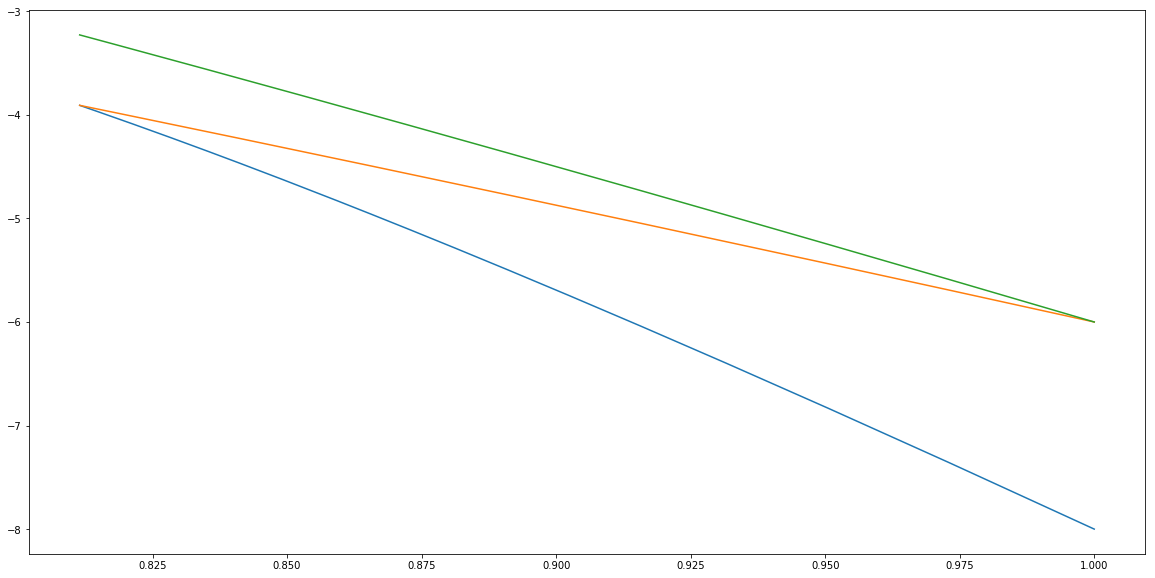

In [850]:
ax.plot(np.array(pacc2), np.array(eacc2[0]))
ax.plot(np.array(pacc2), np.array(eacc2[1]))
ax.plot(np.array(pacc2), np.array(eacc2[2]))
plt.show()

# модиф1 с инверсией и расщеплением как в статье

In [857]:
def Aijm2(cl,size):
    ss = {i for i in range(size)}-{abs(cl[0])-1,abs(cl[1])-1,abs(cl[2])-1}
    i = iter(ss)
    r= next(i)
    s= next(i)
    return 2*mj(size)+\
        mj(size,(abs(cl[0])-1,cx),(abs(cl[1])-1,cx))+\
        mj(size,(abs(cl[1])-1,cx),(abs(cl[2])-1,cx))+\
        mj(size,(abs(cl[2])-1,cx),(abs(cl[0])-1,cx))+\
        mj(size,(r,cx),(s,cx))


In [858]:
Hp3 = sum([Cijm(cl,size)@Aijm2(cl,size)@Cijm(cl,size) for cl in NAE3SAT])
pacc2,eacc2 = BauerFikeStep(Hp3,Hb,accuracy=1e-14)

1 [-8.0, -6.0000000000000036, -6.000000000000003]
0.9979699477712481 [-7.432055953769295, -5.7702579353677965, -5.6714092246400885]
0.9962831793857524 [-6.974554968637486, -5.58261939856411, -5.40222599033936]
0.9948703284325991 [-6.602884600655613, -5.427738535027665, -5.179462066817995]
0.9936775244877807 [-6.29830795551453, -5.298621184718608, -4.993337025537329]
0.9926628163092267 [-6.046533683554952, -5.189981009776981, -4.836422632096744]
0.9917933929770035 [-5.836627244964588, -5.097784816660847, -4.703028740565894]
0.9910434486178663 [-5.660185925052856, -5.018926596861778, -4.5887582453337235]
0.9903925536536652 [-5.510716998147837, -4.950991699152018, -4.490182530075303]
0.9898244178583075 [-5.383171159399036, -4.892085049251142, -4.404603593155633]
0.9893259526321001 [-5.273593498426562, -4.840705246791213, -4.329878822620406]
0.9888865597520837 [-5.1788626698752624, -4.79565169830584, -4.26429120322801]
0.9884975906086254 [-5.096495797076744, -4.755955649396747, -4.20645257

0.9847923619403779 [-4.387092729271535, -4.386940049886594, -3.6663437848941864]
0.984792206966815 [-4.387066023774962, -4.386924972017776, -3.666321619600086]
0.984792063795598 [-4.387041352317937, -4.3869110424639, -3.6663011423844254]
0.9847919315276932 [-4.387018559926226, -4.386898173749014, -3.6662822246544193]
0.9847918093325795 [-4.3869975034406306, -4.386886285064079, -3.666264747617797]
0.9847916964430229 [-4.386978050614949, -4.386875301758305, -3.6662486015349143]
0.9847915921502501 [-4.386960079283348, -4.386865154869517, -3.666233685028481]
0.9847914957994912 [-4.386943476590976, -4.38685578069026, -3.666219904445852]
0.9847914067858619 [-4.386928138283841, -4.386847120367186, -3.666207173269965]
0.9847913245505607 [-4.386913968052714, -4.386839119530898, -3.6661954115753637]
0.9847912485773564 [-4.386900876927082, -4.386831727954179, -3.6661845455256494]
0.9847911783893432 [-4.386888782715683, -4.386824899236241, -3.6661745069093836]
0.9847911135459433 [-4.38687760948944

0.9847903274180256 [-4.386742154584162, -4.386742107208565, -3.6660527976313864]
0.9847903273699382 [-4.386742146298594, -4.386742102530107, -3.666052790753761]
0.9847903273255121 [-4.386742138643875, -4.386742098207868, -3.6660527843997963]
0.9847903272844685 [-4.386742131571949, -4.386742094214703, -3.666052778529602]
0.9847903272465499 [-4.386742125038514, -4.386742090525571, -3.666052773106373]
0.9847903272115184 [-4.386742119002492, -4.386742087117343, -3.6660527680960286]
0.9847903271791542 [-4.3867421134260605, -4.386742083968593, -3.666052763467187]
0.9847903271492541 [-4.386742108274205, -4.386742081059598, -3.6660527591907814]
0.9847903271216305 [-4.3867421035146075, -4.386742078372094, -3.6660527552399884]
0.9847903270961101 [-4.3867420991173764, -4.386742075889192, -3.666052751589964]
0.9847903270725329 [-4.386742095054976, -4.386742073595353, -3.6660527482178864]
0.9847903270507508 [-4.386742091301856, -4.386742071476146, -3.6660527451025238]
0.9847903270306272 [-4.3867420

0.98479032678663 [-4.386742045793259, -4.386742045779664, -3.6660527073271236]
0.9847903267866163 [-4.386742045790903, -4.386742045778341, -3.666052707325147]
0.9847903267866035 [-4.386742045788685, -4.386742045777101, -3.666052707323329]
0.9847903267865917 [-4.386742045786672, -4.386742045775951, -3.6660527073216493]
0.9847903267865808 [-4.386742045784794, -4.386742045774892, -3.6660527073200715]
0.9847903267865707 [-4.386742045783047, -4.386742045773909, -3.666052707318634]
0.9847903267865614 [-4.3867420457814275, -4.386742045772996, -3.666052707317291]
0.9847903267865529 [-4.386742045779968, -4.386742045772173, -3.66605270731608]
0.984790326786545 [-4.386742045778608, -4.386742045771416, -3.6660527073149503]
0.9847903267865377 [-4.386742045777357, -4.386742045770696, -3.6660527073139257]
0.9847903267865309 [-4.386742045776177, -4.386742045770037, -3.6660527073129288]
0.9847903267865247 [-4.386742045775108, -4.386742045769439, -3.6660527073120592]
0.9847903267865189 [-4.3867420457741

In [849]:
print('min',min(np.array(eacc2[1])-np.array(eacc2[0])))
print('max',max(np.array(eacc2[1])-np.array(eacc2[0])))


min 7.105427357601002e-15
max 1.9999999999999991


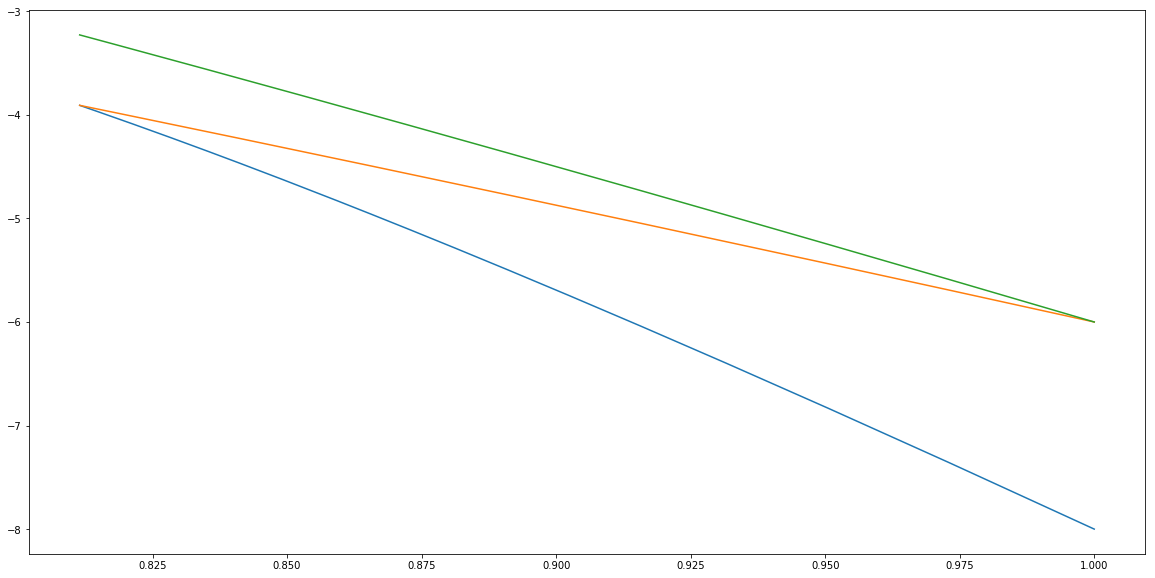

In [850]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(np.array(pacc2), np.array(eacc2[0]))
ax.plot(np.array(pacc2), np.array(eacc2[1]))
ax.plot(np.array(pacc2), np.array(eacc2[2]))
plt.show()